General Functions

In [4]:
import nltk
from nltk.corpus import brown, stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
from collections import Counter
import numpy as np 
import sys
import inspect
import os

# Function to lemmatize words
def lemmatize_word(word, stop_words):
    if not all(char.isalpha() for char in word) or (word in stop_words):
        # Return the word unchanged if it contains digits
        return None
    
    return lemmatizer.lemmatize(word)

def read_categories_files():
    item_types = ['animal', 'body_part', 'vehicle', 'color', 'food', 'fruit']
    types_dict = {}
    for item_type in item_types:
        with open(f'..\\categories_word_list\\{item_type}_list.txt', 'r') as file:
            file_contents = [line.strip().lower() for line in file.readlines()]

        types_dict[item_type] = file_contents

    return types_dict

def get_subwords_per_item(word2vec_model, types_dict, corpus_base_word, words_freq):
    subwords_list_tuple = [] 
    word2_vec_vocab = word2vec_model.vocab
    for word in corpus_base_word:
        for item_category, items in types_dict.items():
            for sub_word in items:
                if (sub_word in word) and (not sub_word == word) and (word2_vec_vocab.get(sub_word) and word2_vec_vocab.get(word)) and\
                    (words_freq[sub_word] != 0 and words_freq[word] != 0):
                    subwords_list_tuple.append((word2vec_model.similarity(sub_word, word), item_category, sub_word, words_freq[sub_word], word, words_freq[word]))  
    
    return subwords_list_tuple

In [2]:
import gensim.downloader as dl

print("Loading word2vec model")
word2vec_model = dl.load("word2vec-google-news-300")
# Download brown corpus
print("Download brown + stopwords vocabularies")
# nltk.download('brown')
# nltk.download('stopwords')

Loading word2vec model


Generate raw dataset

In [ ]:
lemmatizer = WordNetLemmatizer()
# Get all words from the Brown corpus
stop_words = set(stopwords.words('english'))
brown_words = brown.words()
brown_words = list(lemmatize_word(word.lower(), stop_words) for word in brown_words if lemmatize_word(word.lower(), stop_words) is not None)
# Lemmatize each word and keep only the base form
base_words = set(brown_words)
corpus_base_word = list(base_words)
corpus_word_freq = Counter(brown_words)
#corpus_word_freq_df = pd.DataFrame(corpus_word_freq.values(), corpus_word_freq.keys(), columns=["Word_freq"])
types_dict = read_categories_files()
raw_dataset_df = get_subwords_per_item(word2vec_model, types_dict, corpus_base_word, corpus_word_freq)
raw_dataset_df

[(0.07796136, 'vehicle', 'car', 386, 'careworn', 1),
 (0.103255935, 'color', 'red', 201, 'irredentism', 1),
 (0.08844132, 'animal', 'bat', 24, 'batwing', 1),
 (0.04997208, 'animal', 'cat', 41, 'extricate', 2),
 (0.0012959061, 'color', 'red', 201, 'tortured', 9),
 (0.15755908, 'body_part', 'ear', 67, 'speared', 1),
 (0.19401972, 'color', 'red', 201, 'speared', 1),
 (0.15098535, 'fruit', 'pear', 8, 'speared', 1),
 (-0.0112537, 'animal', 'owl', 4, 'foreknowledge', 1),
 (0.009969087, 'animal', 'rat', 9, 'grateful', 25),
 (0.021862503, 'animal', 'rat', 9, 'perpetrated', 3),
 (-0.030021839, 'animal', 'rat', 9, 'declarative', 9),
 (-0.013910112, 'color', 'red', 201, 'demurred', 1),
 (0.024464302, 'color', 'red', 201, 'mannered', 1),
 (0.058350034, 'color', 'red', 201, 'answered', 67),
 (0.006265081, 'color', 'red', 201, 'mortared', 2),
 (0.16913255, 'body_part', 'rib', 12, 'crib', 8),
 (0.04623474, 'animal', 'cat', 41, 'scathing', 1),
 (0.08250499, 'color', 'red', 201, 'dared', 14),
 (0.08962

Generate datasetes for evaluation

In [ ]:
def generate_random_questions(word2vec_model, evaluation_dataset_df, raw_dataset_df, corpus_word_freq_df, K=3):
    random_answers_per_word = []
    word2_vec_vocab = word2vec_model.vocab
    corpus_word_freq_df = corpus_word_freq_df.sort_values(by='Word_freq', ascending=False)
    p_most_freq = 1000
    for _, row in evaluation_dataset_df.iterrows():
        my_categories_subwords = raw_dataset_df[raw_dataset_df['Category'] == row['Category']]
        other_categories_words = corpus_word_freq_df[~corpus_word_freq_df.index.isin(my_categories_subwords['Word'])]
        other_categories_words = other_categories_words[~other_categories_words.index.isin(my_categories_subwords['Subword'])]
        #Get only the P first most freq words and those with length greater than 5
        other_categories_words = other_categories_words[other_categories_words.index.str.len() >= 5]
        other_categories_words = other_categories_words[:p_most_freq]
        for corpus_index, corpus_row in other_categories_words.iterrows():
            if (word2_vec_vocab.get(row['Subword']) and word2_vec_vocab.get(corpus_row.name)):
                other_categories_words.loc[corpus_index, 'Subword_Similiarity'] = abs(word2vec_model.similarity(row['Subword'], corpus_row.name))
            else:
                other_categories_words.loc[corpus_index, 'Subword_Similiarity'] = 0
        
        #Remove similiarty below 0.2
        other_categories_words = other_categories_words[(other_categories_words['Subword_Similiarity'] >= 0.1) & (other_categories_words['Subword_Similiarity'] <= 0.6)]
        other_categories_words.loc[:,'Weights'] = other_categories_words['Word_freq'] / other_categories_words['Word_freq'].sum()
        
        selected_wrong_words = np.random.choice(other_categories_words[:p_most_freq].index, size=K, replace=False, p=other_categories_words['Weights'])
        #selected_wrong_words = np.random.choice(other_categories_words[:p_most_freq].index, size=K, replace=False)
        random_answers_per_word.append((row['Category'], row['Subword'], row['Word'], selected_wrong_words))

    return random_answers_per_word

corpus_word_freq_df = pd.DataFrame(corpus_word_freq.values(), corpus_word_freq.keys(), columns=["Word_freq"])
evaluation_dataset_df = pd.read_csv("..\\datasets\\dataset_for_evaluation.csv")
raw_dataset_df = pd.read_csv("..\\datasets\\raw_dataset.csv")
random_answers_per_word = generate_random_questions(word2vec_model, evaluation_dataset_df, raw_dataset_df, corpus_word_freq_df)
random_answers_per_word

# word distribution (Zipf Law)

In [2]:
import matplotlib.pyplot as plt
from matplotlib.text import Text

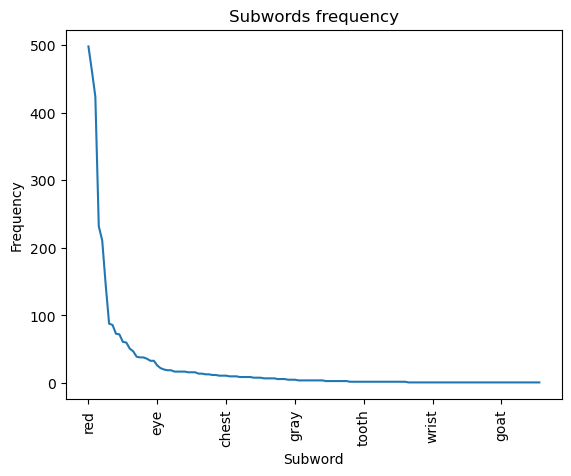

In [5]:
raw_dataset_df = pd.read_csv("..\\datasets\\raw_dataset.csv", index_col=0)
subwords_value_counts = raw_dataset_df['Subword'].value_counts()
ax = subwords_value_counts.plot(title='Subwords frequency', xlabel='Subword', ylabel='Frequency', rot=90)
# num_of_subwords = 20
# jump = int(len(subwords_value_counts)/num_of_subwords)
# list_of_subwords = subwords_value_counts[::jump].index.tolist()
# new_xticks = [r for r in range(0,num_of_subwords*20,20)]
# new_xtickslabels = [Text(r, 0, list_of_subwords[i]) for i, r in enumerate(new_xticks)]
# ax.set_xticks(new_xticks)
# ax.set_xticklabels(new_xtickslabels)
plt.show()
# print(new_xtickslabels)